In [138]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [139]:
file_path = "C:\\Users\\ujwal\\Downloads\\5g-Data-Predictor\\5G_Data_Usage_Prediction_Enhanced.csv"
df = pd.read_csv(file_path)

In [140]:
df.drop(columns=['user_id'], inplace=True)

In [141]:
df.head()

,device_type,app_category,session_duration,data_quality,time_of_day,day_of_week,network_type,signal_strength,prev_usage,location_type,indoor_outdoor,throughput,background_data,data_usage
0,Gaming Console,Gaming,189,Ultra-HD,Night,Monday,Sub-6GHz,-81,1911.154968,Suburban,Outdoor,703,1.059079,3043.864103
1,Smart TV,Video Streaming,215,High,Evening,Sunday,5G NSA,-76,4736.712609,Rural,Outdoor,470,0.182114,4349.832639
2,Tablet,Gaming,217,Low,Afternoon,Wednesday,mmWave,-113,661.030509,Rural,Indoor,50,4.065747,1321.915441
3,Laptop,Browsing,191,High,Evening,Monday,5G SA,-86,4199.863914,Suburban,Outdoor,544,13.249026,2912.923114
4,Laptop,Browsing,295,Ultra-HD,Afternoon,Monday,5G SA,-55,1019.654770,Urban,Indoor,730,10.742657,3743.895694


In [142]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 14 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   device_type       100000 non-null  object 
 1   app_category      100000 non-null  object 
 2   session_duration  100000 non-null  int64  
 3   data_quality      100000 non-null  object 
 4   time_of_day       100000 non-null  object 
 5   day_of_week       100000 non-null  object 
 6   network_type      100000 non-null  object 
 7   signal_strength   100000 non-null  int64  
 8   prev_usage        100000 non-null  float64
 9   location_type     100000 non-null  object 
 10  indoor_outdoor    100000 non-null  object 
 11  throughput        100000 non-null  int64  
 12  background_data   100000 non-null  float64
 13  data_usage        100000 non-null  float64
dtypes: float64(3), int64(3), object(8)
memory usage: 10.7+ MB


In [143]:
df.describe()

,session_duration,signal_strength,prev_usage,throughput,background_data,data_usage
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000
mean,150.624220,-78.828490,2526.237291,567.445940,3.846077,2682.484154
std,86.465573,17.703596,1431.643056,365.570838,3.547780,2445.493352
min,1.000000,-120.000000,50.029965,50.000000,0.000085,0.000000
25%,76.000000,-90.000000,1283.496183,400.000000,1.255913,838.962906
50%,151.000000,-78.000000,2526.890225,550.000000,2.517679,1918.058848
75%,225.000000,-66.000000,3764.844369,706.000000,5.378780,3824.393865
max,300.000000,-41.000000,4999.969015,1690.000000,14.997078,16122.956727


In [144]:
df.isnull().sum()

device_type         0
app_category        0
session_duration    0
data_quality        0
time_of_day         0
day_of_week         0
network_type        0
signal_strength     0
prev_usage          0
location_type       0
indoor_outdoor      0
throughput          0
background_data     0
data_usage          0
dtype: int64

In [145]:
categorical_columns = ['device_type', 'app_category', 'data_quality', 'time_of_day',
                        'day_of_week', 'network_type', 'location_type', 'indoor_outdoor']

In [146]:
df.columns

Index(['device_type', 'app_category', 'session_duration', 'data_quality',
       'time_of_day', 'day_of_week', 'network_type', 'signal_strength',
       'prev_usage', 'location_type', 'indoor_outdoor', 'throughput',
       'background_data', 'data_usage'],
      dtype='object')

In [148]:
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le  # Save encoders for future use

# Handle missing values
df.fillna(df.mean(), inplace=True)

In [149]:
df.corr()

,device_type,app_category,session_duration,data_quality,time_of_day,day_of_week,network_type,signal_strength,prev_usage,location_type,indoor_outdoor,throughput,background_data,data_usage
device_type,1.000000,0.247587,0.006759,-0.001789,0.002846,0.004338,-0.000757,-0.001263,-0.005637,-0.001958,0.000698,0.000443,-0.019454,0.053332
app_category,0.247587,1.000000,0.007831,-0.008525,0.000032,0.005011,-0.000907,-0.009606,0.000522,-0.007915,0.000902,-0.011189,-0.037398,0.255189
session_duration,0.006759,0.007831,1.000000,-0.002002,0.006905,-0.003896,-0.004009,-0.004087,-0.000731,-0.001144,0.001674,-0.004140,-0.001882,0.630945
data_quality,-0.001789,-0.008525,-0.002002,1.000000,-0.000249,0.000274,0.434804,0.521452,0.004652,0.368816,0.133876,0.571757,-0.002039,0.215216
time_of_day,0.002846,0.000032,0.006905,-0.000249,1.000000,-0.000032,0.002415,0.000467,0.005519,0.001017,0.001979,0.000488,0.000881,0.003833
day_of_week,0.004338,0.005011,-0.003896,0.000274,-0.000032,1.000000,0.000950,0.005207,-0.000831,0.003096,-0.000461,0.005164,-0.001967,0.001390
network_type,-0.000757,-0.000907,-0.004009,0.434804,0.002415,0.000950,1.000000,0.002192,0.001836,-0.000088,0.003469,0.090400,0.000143,-0.072895
signal_strength,-0.001263,-0.009606,-0.004087,0.521452,0.000467,0.005207,0.002192,1.000000,0.000097,0.690558,0.285405,0.580019,-0.004087,0.166371
prev_usage,-0.005637,0.000522,-0.000731,0.004652,0.005519,-0.000831,0.001836,0.000097,1.000000,-0.000340,0.002743,0.002942,-0.001434,-0.000177
location_type,-0.001958,-0.007915,-0.001144,0.368816,0.001017,0.003096,-0.000088,0.690558,-0.000340,1.000000,0.000258,0.394610,-0.004217,0.116313


In [150]:
"""Data visulaization"""
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

# Load your dataset (adjust path as needed)
df_original = pd.read_csv("C:\\Users\\ujwal\\Downloads\\5g-Data-Predictor\\5G_Data_Usage_Prediction_Enhanced.csv")
# Group by device_type and app_category, calculate mean data_usage
device_app_usage = df_original.groupby(['device_type', 'app_category'])['data_usage'].mean().reset_index()

# Create a stacked bar chart
fig = px.bar(device_app_usage, x='device_type', y='data_usage', color='app_category',
             title='Average Data Usage by Device Type and App Category',
             labels={'data_usage': 'Average Data Usage (MB)', 'device_type': 'Device Type'},
             color_discrete_sequence=px.colors.qualitative.Pastel,
             height=600)
fig.update_layout(
    xaxis={'tickangle': 45},
    title_font_size=20,
    template='plotly_dark',
    legend_title_text='App Category',
    barmode='stack'  # Stack the bars
)
fig.show()

c:\Users\ujwal\anaconda3\Lib\site-packages\plotly\express\_core.py:1979: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



In [151]:
# Downsample for performance (optional)
df_sample = df_original.sample(5000, random_state=42)

# Create a bubble chart
fig = px.scatter(df_sample, x='throughput', y='data_usage', size='session_duration', color='network_type',
                 title='Data Usage vs. Throughput by Network Type',
                 labels={'throughput': 'Throughput (Mbps)', 'data_usage': 'Data Usage (MB)', 
                         'session_duration': 'Session Duration (min)'},
                 color_discrete_sequence=px.colors.qualitative.Bold,
                 opacity=0.7, height=600)
fig.update_layout(
    template='plotly_dark',
    title_font_size=20,
    legend_title_text='Network Type'
)
fig.show()

c:\Users\ujwal\anaconda3\Lib\site-packages\plotly\express\_core.py:1979: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



In [152]:
# Group by location_type and indoor_outdoor, calculate total data_usage
location_usage = df_original.groupby(['location_type', 'indoor_outdoor'])['data_usage'].sum().reset_index()

# Create a treemap
fig = px.treemap(location_usage, path=['location_type', 'indoor_outdoor'], values='data_usage',
                 title='Data Usage by Location Type and Indoor/Outdoor',
                 color='data_usage', color_continuous_scale='Viridis',
                 height=700)
fig.update_layout(
    template='plotly_dark',
    title_font_size=20
)
fig.show()

In [153]:
# Group by day_of_week and time_of_day, calculate mean data_usage
day_time_usage = df_original.groupby(['day_of_week', 'time_of_day'])['data_usage'].mean().reset_index()

# Create an area chart
fig = px.area(day_time_usage, x='day_of_week', y='data_usage', color='time_of_day',
              title='Data Usage Over Days of the Week by Time of Day',
              labels={'data_usage': 'Average Data Usage (MB)', 'day_of_week': 'Day of Week'},
              color_discrete_sequence=px.colors.qualitative.Set2,
              height=600)
fig.update_layout(
    template='plotly_dark',
    title_font_size=20,
    legend_title_text='Time of Day'
)
fig.show()

c:\Users\ujwal\anaconda3\Lib\site-packages\plotly\express\_core.py:1979: FutureWarning:

When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.



In [154]:
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le  # Save encoders for future use

# Handle missing values
df.fillna(df.mean(), inplace=True)

In [155]:
skewed_features = ['prev_usage', 'throughput', 'background_data']
df[skewed_features] = df[skewed_features].apply(lambda x: np.log1p(x))

# Handle missing values
df.fillna(df.mean(), inplace=True)


In [156]:
X = df.drop(columns=['data_usage'])
y = df['data_usage']
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [157]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [158]:
model = xgb.XGBRegressor(
    objective='reg:squarederror', 
    n_estimators=500,  # Increased from 100
    learning_rate=0.05,  # Reduced from 0.1
    max_depth=8,  # Increased from 6
    subsample=0.8,  # Helps with regularization
    colsample_bytree=0.8,  # Helps avoid overfitting
    random_state=42
)

In [159]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f'Optimized Test MAE: {mae:.4f}')
print(f'Optimized Test RMSE: {rmse:.4f}')

Optimized Test MAE: 31.4670
Optimized Test RMSE: 47.0258


In [162]:
# Train the model
model.fit(X_train, y_train)  

# Predict on test set
y_pred = model.predict(X_test)


In [163]:
from sklearn.metrics import r2_score

# Predict on test set
y_pred = model.predict(X_test)

# Calculate R² Score
r2 = r2_score(y_test, y_pred)
print(f'R² Score: {r2:.4f}')


R² Score: 0.9996


In [167]:
y_test_nonzero = np.where(y_test == 0, np.nan, y_test)  # Replace 0s with NaN
mape = (np.abs((y_test - y_pred) / y_test_nonzero)).mean() * 100  # Recalculate MAPE

print(f"✅ Mean Absolute Percentage Error (MAPE): {mape:.2f}%")


✅ Mean Absolute Percentage Error (MAPE): 4.58%


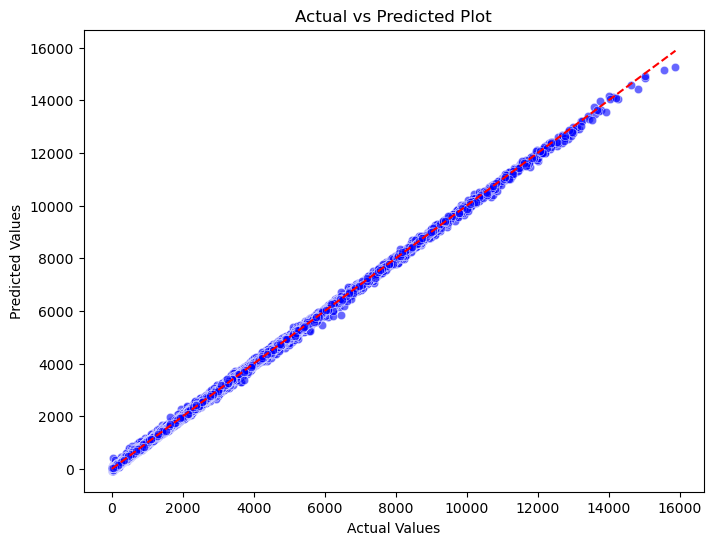

In [169]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, color='blue', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')  # Ideal line
plt.xlabel("Actual Values")
plt.ylabel("Predicted Values")
plt.title("Actual vs Predicted Plot")
plt.show()


c:\Users\ujwal\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning:

use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.



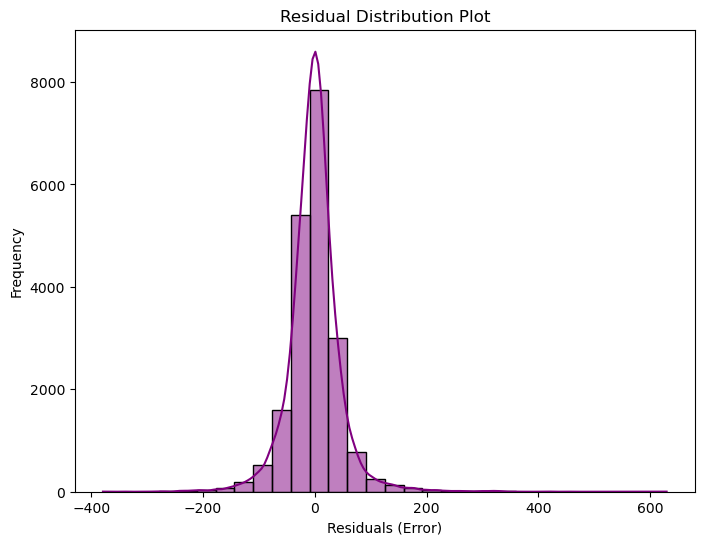

In [170]:
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
sns.histplot(residuals, bins=30, kde=True, color='purple')
plt.xlabel("Residuals (Error)")
plt.ylabel("Frequency")
plt.title("Residual Distribution Plot")
plt.show()


In [174]:
"""saving the model"""
import joblib

# Save the model
joblib.dump(model, "xgboost_model.pkl")

# Load the model later
loaded_model = joblib.load("xgboost_model.pkl")

# Predict using loaded model
y_pred = loaded_model.predict(X_test)
